# About

- `Title:` "Supervised Learning with Quantum-Inspired Tensor Networks"
- `Main Author:` Miles E. Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1605.05775)
- `Publish Date:` 18-05-2017
- `Reviewed Date:` 22-10-2021

## Citation

```latex
@article{stoudenmire2016supervised,
  title={Supervised learning with tensor networks},
  author={Stoudenmire, Edwin and Schwab, David J},
  journal={Advances in Neural Information Processing Systems},
  volume={29},
  year={2016}
}
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


# Installing dependencies

In [3]:
# uncomment the line below when running for the first time
# !pip install --upgrade jax jaxlib matplotlib

# Imports and settings

In [4]:
import jax
import jax.numpy as jnp

In [5]:
import itertools
import functools

In [6]:
from typing import Any, List, Tuple, Callable, Optional

In [7]:
from plotting import plot, show_img_grid, set_figsize

In [8]:
import dataset  # MNIST downloader

## Type Aliaces

In [9]:
# type alias
Key = Any

Scalar = jnp.double
Vector = jnp.ndarray
Matrix = jnp.ndarray
Tensor = jnp.ndarray

MPS = List[Tensor]

# Constants

In [10]:
# WARNING: to avoid unnecessary truncation, set bond_dim>=num_classes
bond_dim = 20       # the paper mentions 10, 20 and 120
                    
α = 5e-5            # learning rate
num_sweeps = 10     # number of sweeps
train_size = 20000  # training set size

# PRN Key

In [11]:
key = jax.random.PRNGKey(seed=321)

# Load data and visualise

In [12]:
train_images, train_labels, test_images, test_labels = dataset.mnist()

In [13]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (60000, 784) | Test data shape: (10000, 784)


Subsample data to reduce numerical cost.

In [14]:
def subsample_data(
        key: Key, 
        data: Matrix, 
        amount: int
    ) -> Matrix:
    """A helper to sub-sample data"""
    samples, labels = data        
    new_key, _ = jax.random.split(key)
    idx = jnp.arange(labels.shape[0])
    perm = jax.random.permutation(new_key, idx)
    return samples[perm][:amount], labels[perm][:amount]

train_images, train_labels = subsample_data(key, data=(train_images, train_labels), amount=train_size)

In [15]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (20000, 784) | Test data shape: (10000, 784)


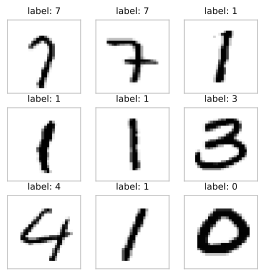

In [16]:
set_figsize((4.5,4.5))

img_shape = (28, 28)

show_img_grid(
    [train_images[i].reshape(img_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Downscaling images as in paper

In [17]:
def resize_img(
        img_vec: Vector,
        shape: Tuple[int,int]
    ) -> Vector:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img_mat = img_vec.reshape(orig_size, orig_size)
    img_mat = jax.image.resize(img_mat, shape, method='nearest')
    return img_mat.reshape(-1)

Resizing images to $14 × 14$ as in the paper.

In [18]:
img_shape = (14,14)

resize_img_vmap = functools.partial(resize_img, shape=img_shape)

train_images_scaled = jax.vmap(resize_img_vmap)(train_images)
test_images_scaled = jax.vmap(resize_img_vmap)(test_images)

In [19]:
print(f'Train data shape: {train_images_scaled.shape} | Test data shape: {test_images_scaled.shape}')

Train data shape: (20000, 196) | Test data shape: (10000, 196)


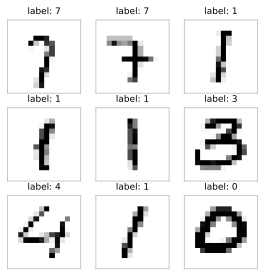

In [20]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images_scaled[i].reshape(img_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Feature Map

In [21]:
def feature_map(x: Scalar) -> Vector:
    """Definine a feature map per pixel"""
    return jnp.asarray([
        jnp.cos(0.5 * jnp.pi * x),
        jnp.sin(0.5 * jnp.pi * x)
    ])

In [22]:
# applying the feature map in vectorized form
# exchanging axes for convenience (leading axes have the largest dimensions)
train_samples = jax.vmap(feature_map)(train_images_scaled).transpose(0,2,1)  
test_samples = jax.vmap(feature_map)(test_images_scaled).transpose(0,2,1)

In [23]:
print(f'Train data shape: {train_samples.shape} | Test data shape: {test_samples.shape}')

Train data shape: (20000, 196, 2) | Test data shape: (10000, 196, 2)


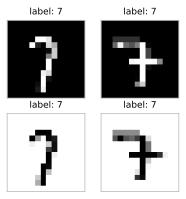

In [24]:
set_figsize((3.1,3.1))

# printing some images after the feature extraction
show_img_grid(
    [train_samples[i,:,j].reshape(img_shape) for j in range(2) for i in range(2)],
    [f'label: {jnp.argmax(train_labels[i])}' for i in range(2)] * 2,
)

## MPS Utilities

In [25]:
def random_mps(
        key: Key,
        initializer: Callable,
        size: int,
        local_dim: int,
        bond_dim: int,
        labels_dim: Optional[int]=1,
    ) -> MPS:
    """
    Generate a random MPS where each core tensor
    is drawn according to the given initializer (see JAX docs).
    The result is a list of tensors indexed as follows:
    0 --o-- 2
        |    
        1    
    If the labels_dim is provided, it is set at the last tensor.
    """
    left   = (1, local_dim, bond_dim)
    right  = (bond_dim, local_dim, labels_dim)
    middle = (bond_dim, local_dim, bond_dim)

    if size < 2:
        raise ValueError('Expectetd at least 2 sites for the MPS')
    elif size == 2:
        shapes = [left, right]
    else:       
        shapes = [left] + [middle]*(size-2) + [right]

    # generate multiple keys, so all tensors are different
    keys = jax.random.split(key, num=size)

    return jax.tree_map(initializer, list(keys), shapes)

In [26]:
def reverse_mps(
        params: MPS, 
        swapaxes: Optional[Tuple[int,int]]=(0,2)
    ) -> MPS:
    """
    A helper to reverse the MPS from left to right.
    The left and right legs are interchanged.
    The default change of indexing is as follows:
    0 --o-- 2     2 --o-- 0 
        |     =>      |
        1             1
    """
    swap_legs = lambda t: t.swapaxes(*swapaxes).conj()
    return jax.tree_map(swap_legs, params[::-1])

In [27]:
def reverse_data(
        params: MPS, 
        samples: Tensor,
        wings: List[Matrix]
    ) -> Tuple[MPS, Tensor, List[Matrix]]:
    """A helper to reverse main data arounnd the features axis"""
    params_rev = reverse_mps(params)
    samples_rev = jnp.flip(samples, axis=1)
    wings_rev = wings[::-1]
    return params_rev, samples_rev, wings_rev

# Training-Related Functions

In [28]:
def project_sample(
        params: MPS, 
        sample: Matrix
    ) -> List[Matrix]:
    """
    A helper to project a single sample onto the MPS
    sites, i.e. contracting the local dimension only.
    --o--o--...--o--     
      |  |       |   => --o--o--...--o--
      o  o       o
    """
    # accounting for the possible labels dimension
    mult = lambda t, s: jnp.einsum('pjq...,j->pq...', t, s)
    return jax.tree_map(mult, params, list(sample))

def project_samples(
      params: MPS, 
      samples: Tensor
    ) -> List[Tensor]:
    """Projects multiple samples onto the MPS"""
    proj_func = functools.partial(project_sample, params)
    return jax.vmap(proj_func)(samples)

In [29]:
def loss(
        bond_tensor: Tensor,
        data: Tuple[List[Tensor], Matrix]
    ) -> Scalar:
    """Squared loss function"""
    # (Φ̃, δℓ) = data
    feats, labels = data
    # Fig. 6c (fℓ(xₙ))
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *feats, bond_tensor)
    err = preds - labels
    # implicit double sum in Eq.6
    return 0.5 * jnp.sum(jnp.power(err, 2))

In [30]:
def grad(
        bond_tensor: Tensor,
        data: Tuple[List[Tensor], Matrix]
    ) -> Scalar:
    """Manually calculate the squared loss gradient - Fig.6(c-d)"""
    # (Φ̃, δℓ) = data
    feats, labels = data
    # Fig. 6c (fℓ(xₙ))
    preds = jnp.einsum('mp,mij,mq,pijql->ml', *feats, bond_tensor)
    # Fig. 6d
    err = preds - labels
    # positive gradient
    return jnp.einsum('mp,mij,mq,ml->pijql', *feats, err)

In [31]:
def predict_label(
        params: MPS, 
        sample: Matrix
    ) -> Scalar:
    """A helper to predict the label for a single sample"""
    # project the test sample onto the mps
    projs = project_sample(params, sample)
    # reduce (full contraction)
    preds = functools.reduce(
        lambda x, y: jnp.einsum('pi...,iq...->pq...', x, y),
        projs
    )
    return jnp.argmax(preds)

def predict_labels(
        params: MPS, 
        samples: Tensor
    ) -> Scalar:
    """A helper to predict the label for a single sample"""
    pred_func = functools.partial(predict_label, params)
    return jax.vmap(pred_func)(samples)

In [32]:
def error_rate(
        params: List[Tensor], 
        data: Tuple[Tensor, Matrix]
    ) -> Scalar:
    """A helper to compute the error rate"""
    samples, labels_oh = data
    # undo one-hot encoding of the labels
    labels = jnp.argmax(labels_oh, axis=1)
    # predict labels for all samples
    labels_pred = predict_labels(params, samples)
    return 1 - jnp.sum(labels == labels_pred) / labels.size

# Initialize MPS

In [33]:
# getting the parameters
num_samples, num_features, dim_features = train_samples.shape
num_classes = train_labels.shape[1]

# initializer
initializer = jax.nn.initializers.uniform(scale=1)

# generating a random mps according to the initialiser
mps = random_mps(
    key, 
    initializer, 
    size=num_features, 
    local_dim=dim_features, 
    bond_dim=bond_dim, # WARNING: to avoid unnecessary truncation, set bond_dim >= num_classes 
    labels_dim=num_classes
)

print(f'The MPS dimensions: size={num_features}, local_dim={dim_features}, bond_dim={bond_dim}')
print(f'Total number of paramters: {bond_dim**2 * dim_features * num_features}')

The MPS dimensions: size=196, local_dim=2, bond_dim=20
Total number of paramters: 156800


In [34]:
def left_normalize(
        params: MPS, 
        max_bond: int
    ) -> MPS:
    """Normalise the mps into the left-canonical form"""
    size = len(params)
    for pos in range(size):
        p, j, *_ = params[pos].shape
        M = params[pos].reshape(p*j,-1)
        # perform SVD
        U, λ, Vh = jnp.linalg.svd(M, full_matrices=False)
        # cutting off the bond dimension
        U  = U[:,:max_bond]   # truncate columns
        λ  = λ[:max_bond]     # truncate singular values
        Vh = Vh[:max_bond,:]  # truncate rows
        # assign the current tensor to U and reshape
        params[pos] = U.reshape(-1, j, U.shape[1])
        # assigining the labels to the next tensor and reshape
        if pos < size - 1:
            M_next = params[pos+1].reshape(Vh.shape[1], -1)
            params[pos+1] = jnp.einsum('i,ij,jk->ik', λ, Vh, M_next).reshape(U.shape[1], j, -1)
    return params

In [35]:
# left normalizing the mps
mps = left_normalize(mps, max_bond=bond_dim)

In [36]:
# checking that the resulting mps is in the left-canonical form
mult = lambda e, t: jnp.einsum('pq,pjr,qjv->rv', e, t.conj(), t)
assert jnp.allclose(functools.reduce(mult, mps, jnp.eye(1)), jnp.eye(mps[-1].shape[-1]))

In [37]:
# reversing the mps gives the right-canonical form
mps_rev = reverse_mps(mps)
mult_rev = lambda e, t: jnp.einsum('rv,pjr,qjv->pq', e, t, t.conj())
# to apply the reduce function, we need to change the mps ordering (no leg swapping!)
assert jnp.allclose(functools.reduce(mult_rev, mps_rev[::-1], jnp.eye(1)), jnp.eye(mps_rev[0].shape[0]))

In [38]:
# extract the dimension corresponding to
# the labels, so we can move it during optimisation
mps[-1] = jnp.expand_dims(mps[-1], axis=2)

In [39]:
# printing shapes of the first and the last three tensors
print([t.shape for t in (*mps[:3],*mps[-3:])])

[(1, 2, 2), (2, 2, 4), (4, 2, 8), (20, 2, 20), (20, 2, 20), (20, 2, 1, 10)]


# Initialise the data store for the "left/right wings"

Initialise the data structure to store left/right wings. For the motivation, see the last paragraph on p4 in the paper. Below, I assume that the tensor with labels is the last in the MPS. After the initialisation, the order of the wings is reversed to allow the sweeps from the left on each run (with the labels being attached to the first tensor after reverting the order). This trick allows to move from left to right on every sweep simply by reverting the MPS, data features and the wings.

In [40]:
def norm_normalize(v: Vector) -> Vector:
    return v / jnp.linalg.norm(v)

In [41]:
def init_wings(
        params: MPS,
        samples: Tensor,
    ) -> List[Vector]:
    """
    Initialise the local projections to keep linear
    scaling of the whole algorithm wrt sample size.
     ---  ∘-> move the box       ------   
    | o-|-o--o--...--o--o       | ▩--o-|--o--...--o--o      ▩--o--o
    | | | |  |       |  |   =>  |    | |  |       |  |  =>     |  |
    | o | o  o       o  o       |    o |  o       o  o         o  o
     ---                         ------
    """        
    # get the projections of samples onto the mps sites (excet the last two sites)
    projs = project_samples(params=params[:-2], samples=samples[:,:-2,:])

    # helper to contract neighbouring sites
    mult = lambda x, y: jnp.einsum('mpi,miq->mpq', x, y)
    # get the cumulative products computed from left to right
    cum_prods = itertools.accumulate(projs, mult)
    # normalize to norm 1
    wings = jax.tree_map(jax.vmap(norm_normalize), list(cum_prods))
    # the last two sites are dummy
    return jax.tree_map(jnp.squeeze, wings) + [jnp.asarray(None)]*2 

In [42]:
# initialize the wings
wings = init_wings(mps, train_samples)

# Main Loop

In [43]:
def project_sample(
        params: MPS, 
        sample: Matrix
    ) -> List[Matrix]:
    """
    A helper to project a single sample onto the MPS
    sites, i.e. contracting the local dimension only.
    --o--o--...--o--     
      |  |       |   => --o--o--...--o--
      o  o       o
    """
    # accounting for the possible labels dimension
    mult = lambda t, s: jnp.einsum('pjq...,j->pq...', t, s)
    return jax.tree_map(mult, params, list(sample))

In [44]:
max_bond = bond_dim

grads, losses = [], []

for sweep in range(num_sweeps):

    print('*'*100 + f'\nSweep: {sweep + 1}\n' + '*'*100)

    # reverse data for convenience, so the iterations 
    # are from left to right. Note, that the initiali left 
    # normalization of the MPS results in the right 
    # normalization after the operation (as shown above)
    mps, train_samples, wings = reverse_data(mps, train_samples, wings)

    for pos in range(len(mps) - 1):

        # bond tensor - Fig.6a
        B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])

        # composing a tensor Φ - Fig.6b
        if pos == 0:
            left_wing = jnp.ones(shape=(num_samples, 1))   # dummy
            right_wing = wings[pos+2]
        elif pos == len(mps)-2:
            left_wing = wings[pos-1]
            right_wing = jnp.ones(shape=(num_samples, 1))  # dummy
        else:
            left_wing = wings[pos-1]
            right_wing = wings[pos+2]

        # not yet combining to a single tensor - saving space
        Φ = [left_wing, train_samples[:,pos:pos+2,:], right_wing]

        # compute the gradient update - Fig.6(c-d)
        ΔB = grad(B, data=(Φ, train_labels))
        
        # update the bond tensor - Fig.7a
        # note, that the paper is using the 
        # negative gradient instead, so the 
        # plus sign there
        B -= α * ΔB

        # SVD
        p,i,j,q,l = B.shape
        U, λ, Vh = jnp.linalg.svd(B.reshape(p*i, -1), full_matrices=False)

        # cutting off the bond dimension
        if λ.size > max_bond:
            # max_bond = suggest_truncation(λ, ε)  # adaptive bond dimension
            U  = U[:,:max_bond]
            λ  = λ[:max_bond]
            Vh = Vh[:max_bond,:]

        # normalize spectra to have norm 1
        λ = norm_normalize(λ)
        
        # updating mps tesnors - Fig.7b
        mps[pos]   = U.reshape(-1,i,U.shape[1])  # current position
        mps[pos+1] = jnp.einsum('i,ij->ij', λ, Vh).reshape(-1,j,q,l)  # next position

        # project input samples onto the new tensor at current position and update the left wing - Fig.7c
        projs_at_pos = project_samples(params=mps[pos:pos+1], samples=train_samples[:,pos:pos+1,:])

        # updating the left wing; squeezing 0 index due to len(MPS) = 1
        left_wing = jnp.einsum('mp,mpq->mq', left_wing, jnp.asarray(projs_at_pos).squeeze(axis=0))

        # normalize and update the wing
        wings[pos] = jax.vmap(norm_normalize)(left_wing)

        # store for the analysis
        grads.append(jnp.linalg.norm(ΔB))
        losses.append(loss(B, data=(Φ, train_labels)))

        print(
            '\t|\t'.join(
                [f'Updated site: {pos:<4}',
                 f'Loss: {losses[-1]:<6e}',
                 f'Gradient norm: {grads[-1]:<6e}',
                 f'Bond Dim: {max_bond:<3}',
                ])
        )

grads = jnp.asarray(grads)
losses = jnp.asarray(losses)

****************************************************************************************************
Sweep: 1
****************************************************************************************************
Updated site: 0   	|	Loss: 1.075503e+04	|	Gradient norm: 1.190276e+04	|	Bond Dim: 20 
Updated site: 1   	|	Loss: 9.970764e+03	|	Gradient norm: 8.872519e+03	|	Bond Dim: 20 
Updated site: 2   	|	Loss: 9.209258e+03	|	Gradient norm: 4.100399e+03	|	Bond Dim: 20 
Updated site: 3   	|	Loss: 9.134849e+03	|	Gradient norm: 3.379366e+03	|	Bond Dim: 20 
Updated site: 4   	|	Loss: 9.081336e+03	|	Gradient norm: 2.602181e+03	|	Bond Dim: 20 
Updated site: 5   	|	Loss: 9.011756e+03	|	Gradient norm: 1.064453e+03	|	Bond Dim: 20 
Updated site: 6   	|	Loss: 9.098638e+03	|	Gradient norm: 2.860679e+03	|	Bond Dim: 20 
Updated site: 7   	|	Loss: 9.109741e+03	|	Gradient norm: 3.013047e+03	|	Bond Dim: 20 
Updated site: 8   	|	Loss: 9.036065e+03	|	Gradient norm: 1.744798e+03	|	Bond Dim: 20 
Updated site: 9

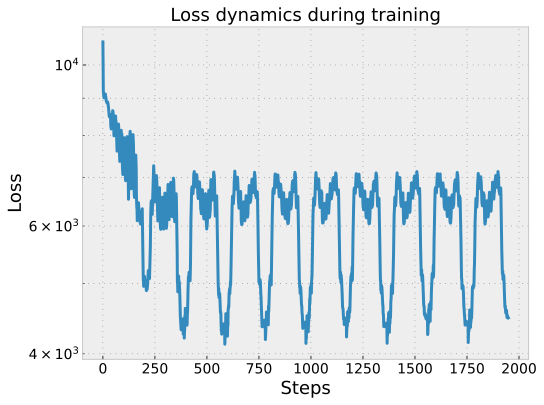

In [45]:
losses = jnp.asarray(losses)

plot(
    jnp.arange(losses.size), [losses], 
    yscale='log',
    xlabel='Steps',
    ylabel='Loss',
    title='Loss dynamics during training')

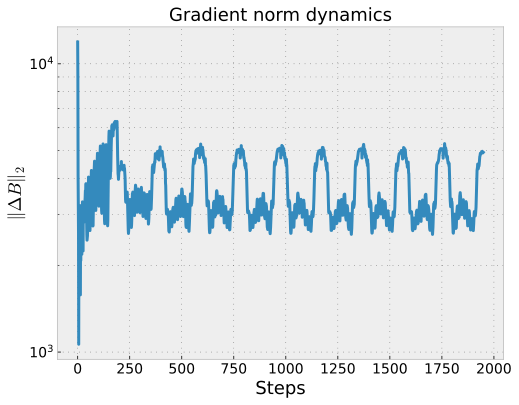

In [46]:
grads = jnp.asarray(grads)

plot(
    jnp.arange(grads.size), 
    [grads],
    yscale='log',
    xlabel='Steps',
    ylabel='$\|\Delta{B}\|_2$',
    title='Gradient norm dynamics'
    )

# Calculating The Error Rate

In [47]:
er_train = error_rate(mps, data=(train_samples, train_labels))
er_test = error_rate(mps, data=(test_samples, test_labels))

In [48]:
print(f'Error rate train: {er_train:<5.2f}\t|\tError rate test: {er_test:<5.2f}')

Error rate train: 0.14 	|	Error rate test: 0.13 


# Varia

Below is a piece of code that was used to check if the gradient is computed correctly. The plotted two lines must be parallel to each other if this is the case (up to some numerical accuracy).

In [49]:
# def plot_taylor_apprx(β, data, num_iter=30):
#     dotp = lambda x,y : jnp.einsum('...,...->', x, y)
#     dβ = grad(β, data)
#     Δ = jax.random.uniform(key, shape=β.shape)
#     f = loss(β, data)

#     apprx, norms = [], []
#     for _ in range(num_iter):
#         Δf = loss(β + Δ, data)
#         apprx.append(jnp.linalg.norm(Δf - f - dotp(dβ, Δ)))
#         norms.append(dotp(Δ, Δ))
#         Δ /= 2

#     plot(jnp.arange(num_iter), [apprx, norms],
#          yscale='log', legend=['$\|f(x+Δx) - f(x) - ⟨∇f,Δx⟩\|^2$', '$\|Δx\|^2$'],
#          xlabel='Iterations', ylabel='$log{\|\cdot\|^2}$')

# pos = 0
# B = jnp.einsum('pikl,kjq->pijql', mps[pos], mps[pos+1])
# inputs = train_samples[:,pos:pos+2,:]
# left_wing = jnp.ones(shape=(num_samples,1))
# Φ = [left_wing, inputs, wings[pos+2]]

# plot_taylor_apprx(B, data=(Φ, train_labels))

The code below was tried to adaptively change bond dimensions, but it did not show any visible improvement.

In [50]:
# def suggest_truncation(
#         λ: Vector,
#         ε: float,      # truncation error tolerance
#     ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
#     """
#     Suggest a truncation index of the spectrum 
#     such that the truncation error is lower than ε.
#     The spectrum is assumed to be in the descending order.
#     """
#     cum_sums = jnp.cumsum(λ / jnp.sum(λ))
#     return jnp.searchsorted(cum_sums, 1-ε)